# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
feat_info['information_level'].unique()

array(['person', 'household', 'building', 'microcell_rr4', 'microcell_rr3',
       'postcode', 'region_rr1', 'macrocell_plz8', 'community'], dtype=object)

In [8]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [9]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

# Create copies of each dataset to work on
feat_info_cp = feat_info.copy()
azdias_cp = azdias.copy()

# Check missing_or_unknown value before cleaning
feat_info_cp['missing_or_unknown'][0]

'[-1,0]'

In [11]:
# Clean and transform the 'missing_or_unknown' column from strings to NumPy arrays
feat_info_cp['missing_or_unknown'] = feat_info_cp['missing_or_unknown'].str.strip('[]').str.split(',').map(np.array)

Source for above code is: https://stackoverflow.com/questions/67841257/convert-object-column-to-array-type-pandas-dataframe

In [12]:
# Check missing_or_unknown value after cleaning
feat_info_cp['missing_or_unknown'][0]

array(['-1', '0'], 
      dtype='<U2')

In [13]:
# Change 'attribute' column to index
feat_info_cp = feat_info_cp.set_index('attribute')

In [14]:
# Convert all possible missing_or_unknown number values in feat_info_cp from strings to floats
feat_info_cp['missing_or_unknown'] = feat_info_cp['missing_or_unknown'].apply(lambda x: [float(val) if (val != 'X' and val !='XX' and val != '') else val for val in x])

In [15]:
# Convert azdias Missing Value Codes to NaNs
for col in azdias_cp.columns:
    try:
        azdias_cp[col].replace(feat_info_cp.loc[col].loc['missing_or_unknown'],np.nan,inplace=True)
    except:
        continue

In [16]:
# Reset Index
feat_info_cp = feat_info_cp.reset_index()

In [17]:
azdias_cp.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Find null values before cleanup
print('Before transforming missing values:', sum(azdias.isnull().sum()))

# Find new null values
print('After transforming missing values:', sum(azdias_cp.isnull().sum()))

Before transforming missing values: 4896838
After transforming missing values: 8373929


In [19]:
num_col_null_azdias = azdias_cp.isnull().sum()
print(num_col_null_azdias)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [20]:
# Investigate patterns in the amount of missing data in each column.
num_col_null_azdias.to_frame()

,0
AGER_TYP,685843
ALTERSKATEGORIE_GROB,2881
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0
FINANZ_UNAUFFAELLIGER,0
FINANZ_HAUSBAUER,0


In [21]:
num_col_null_azdias.sort_values()

ZABEOTYP                      0
SEMIO_TRADV                   0
SEMIO_PFLICHT                 0
SEMIO_KAEM                    0
SEMIO_DOM                     0
SEMIO_KRIT                    0
SEMIO_RAT                     0
SEMIO_KULT                    0
SEMIO_ERL                     0
SEMIO_LUST                    0
SEMIO_VERT                    0
SEMIO_MAT                     0
SEMIO_REL                     0
SEMIO_SOZ                     0
SEMIO_FAM                     0
FINANZ_VORSORGER              0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
FINANZTYP                     0
ALTERSKATEGORIE_GROB       2881
GFK_URLAUBERTYP            4854
LP_STATUS_GROB             4854
LP_STATUS_FEIN             4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
                          ...  
CAMEO_IN

In [22]:
# Calculate proportion of null values
percent_col_null_azdias = (num_col_null_azdias/len(azdias_cp))*100

In [23]:
percent_col_null_azdias.describe()

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64

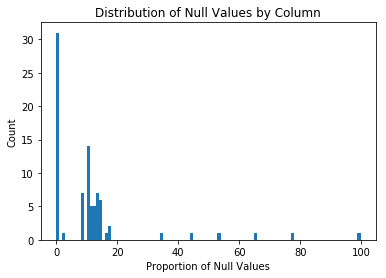

In [24]:
# How much data is missing in each row of the dataset?
plt.hist(percent_col_null_azdias, bins=100)
plt.title('Distribution of Null Values by Column')
plt.ylabel('Count')
plt.xlabel('Proportion of Null Values')
plt.show()

Text(0,0.5,'Proportion of Null Values')

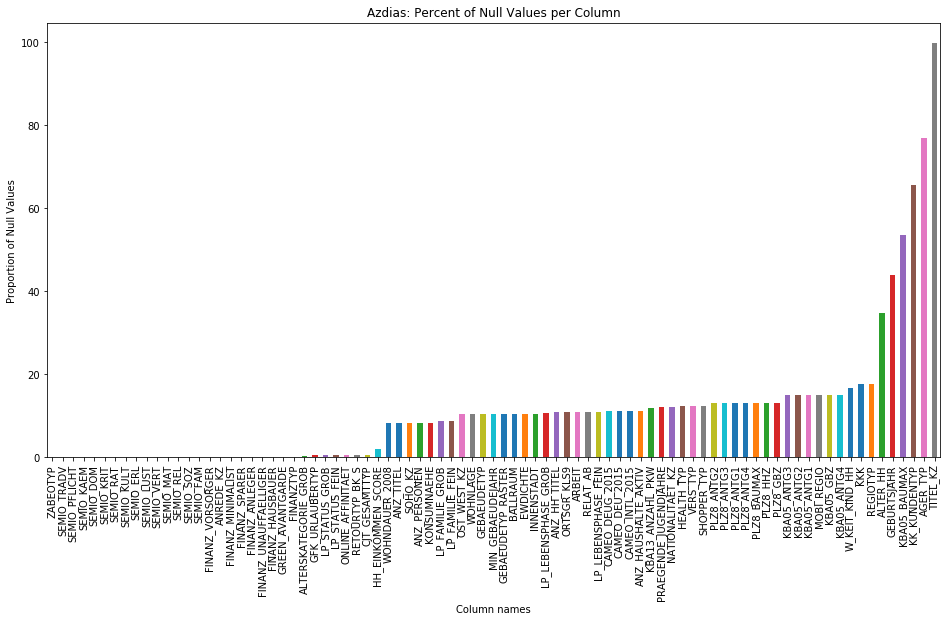

In [25]:
percent_col_null_azdias.sort_values().plot(kind="bar", figsize=(16,8))
plt.title("Azdias: Percent of Null Values per Column")
plt.xlabel("Column names")
plt.ylabel("Proportion of Null Values")

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Create list of columns to drop
col_to_drop = percent_col_null_azdias[percent_col_null_azdias > 20].keys().tolist()

# Drop null outlier columns 
azdias_cp = azdias_cp.drop(col_to_drop, axis=1)

In [27]:
print(azdias.shape)
print(azdias_cp.shape)

(891221, 85)
(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column
> The histogram shows that for most of the columns the amount of missing data was less than 20%. It also seems like the amount of missing data in each column is a similar percentage where there is missing or null data in the columns and may be due to specific rows with data issues. The bar graph shows more clearly that the outliers for missing data were all above 20% and had almost double the amount of missing values compared to other columns, so these 6 columns were removed: `ALTER_HH`, `GEBURTSJAHR`, `KBA05_BAUMAX`, `KK_KUNDENTYP`, `AGER_TYP`, `TITEL_KZ`


> For future tests some of these outlier columns probably would be useful, as some of them pertain to consumer age and patterns, and could be estimated or calculated. The two columns with the most missing informationm,`AGER_TYP`, `TITEL_KZ`, probably should still be removed due to only having 20% of the data being usable and would not be easily replaced or re-encoded. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# How much data is missing in each row of the dataset?
num_row_null_azdias = azdias_cp.isnull().sum(axis=1)
num_row_null_azdias.to_frame()

,0
0,43
1,0
2,0
3,7
4,0
5,0
6,0
7,0
8,0
9,0


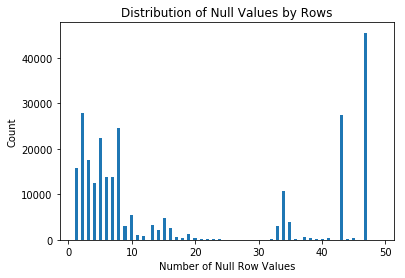

In [29]:
# How much data is missing in each row of the dataset?
plt.hist(num_row_null_azdias[num_row_null_azdias != 0], bins=100)
plt.title('Distribution of Null Values by Rows')
plt.ylabel('Count')
plt.xlabel('Number of Null Row Values')
plt.show()

In [30]:
azdias_cp.isna().sum().sum()

5035304

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_lt = azdias_cp[(azdias_cp.isnull().sum(axis=1) >= 9) & (azdias_cp.isnull().sum(axis=1) <= 32)]
azdias_ut = azdias_cp[(azdias_cp.isnull().sum(axis=1) < 9) | (azdias_cp.isnull().sum(axis=1) > 32)]

In [32]:
#Checking lower threshold null values
azdias_lt.isna().sum().sum()

358212

In [33]:
#Checking upper threshold null values
azdias_ut.isna().sum().sum()

4677092

In [34]:
#Checking split null values combined
azdias_ut.isna().sum().sum() + azdias_lt.isna().sum().sum()

5035304

Columns to compare:  ['ZABEOTYP', 'SEMIO_RAT', 'SEMIO_REL', 'FINANZ_SPARER', 'ALTERSKATEGORIE_GROB']


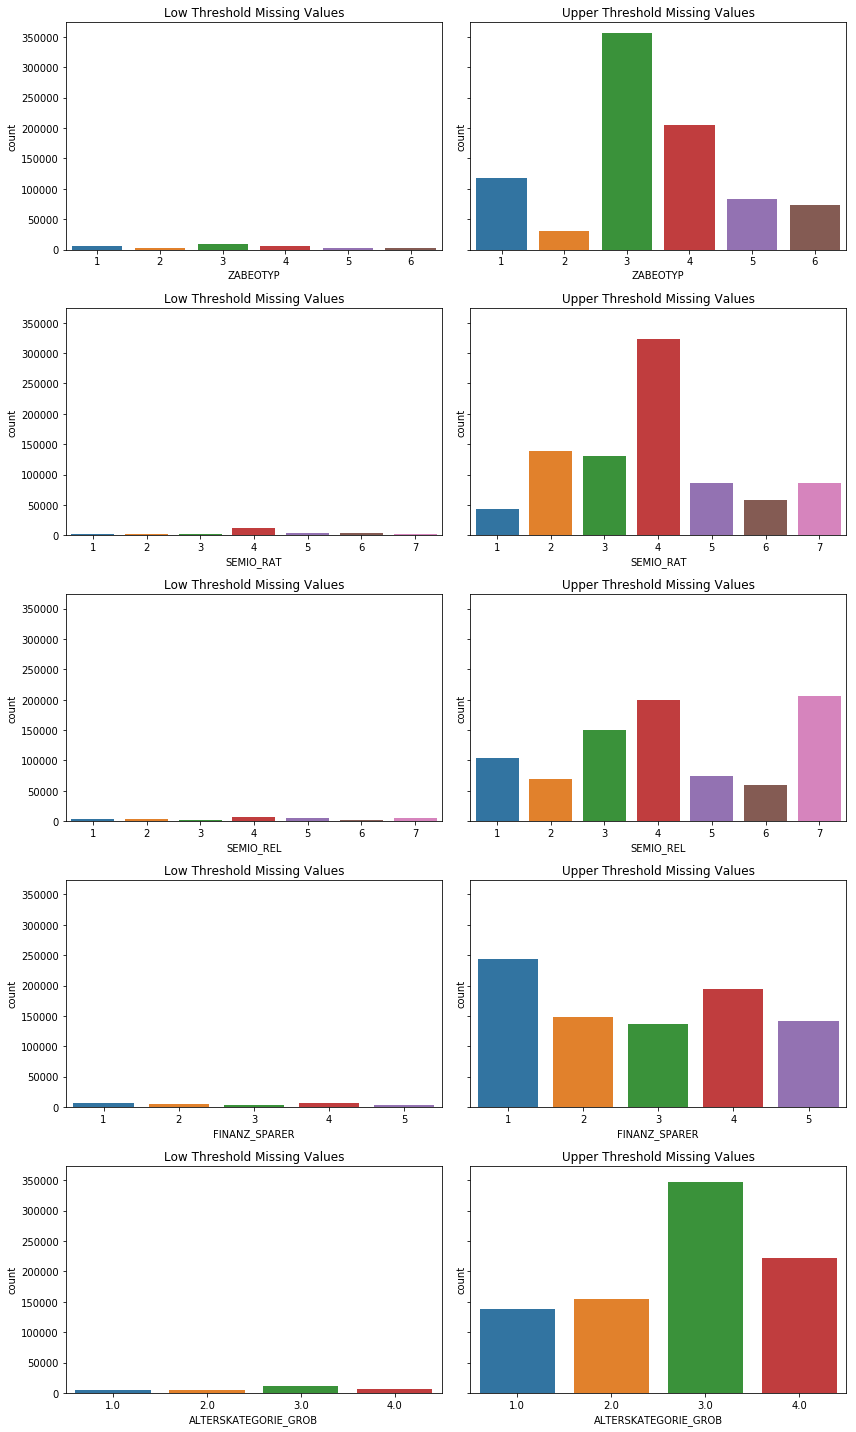

In [35]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# How much data is missing in each row of the dataset?

# Create list of 5 column names from the first 30 with lowest missing values.
col_compare_notnull = num_col_null_azdias.sort_values()[:30:6].index.tolist()

def compare_dist_columns(columns):
    """
    Plots count of missing values for each column in two subplots, 
    comparing the distribution of missing values in each row.

    Parameters:
    columns (list): List of column names to compare.
    """
    print('Columns to compare: ', col_compare_notnull)

    fig, ax = plt.subplots(nrows=(len(columns)), sharey=True, ncols=2, figsize=(12,20))
    
    for indx in range(len(columns)):
        sns.countplot(azdias_lt[columns[indx]], ax=ax[indx][0])
        ax[indx][0].set_title('Low Threshold Missing Values')
        
        sns.countplot(azdias_ut[columns[indx]], ax=ax[indx][1])
        ax[indx][1].set_title('Upper Threshold Missing Values')
        fig.tight_layout()
        
        
compare_dist_columns(col_compare_notnull)

#### Discussion 1.1.3: Assess Missing Data in Each Row
> The distribution of missing data between the datasets split by missing row values are significantly different based on the graphs above and should be revisited later. This also indicates that for now we should continue the analysis using just the subset of the data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
feat_info_cp.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1.0]


In [37]:
# How many features are there of each data type?
features_attribute = feat_info_cp[feat_info_cp['attribute'].isin(azdias_lt.columns.tolist())]
features_attribute['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [38]:
# Looking at Ordinal data
ordinal = features_attribute[features_attribute['type']=='ordinal']
ordinal_col = ordinal['attribute'].tolist()
azdias_lt[ordinal_col].head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
20,2.0,4,3,1,4,5,1,3.0,5.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,1.0
26,3.0,5,2,4,2,3,1,1.0,3.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
138,3.0,5,3,4,2,4,1,1.0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,3.0
142,2.0,3,3,2,2,5,1,2.0,2.0,4,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,6.0,2.0
143,3.0,3,3,4,3,3,1,2.0,3.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,1.0


In [39]:
# Looking at Numeric data
numeric = features_attribute[features_attribute['type']=='numeric']
numeric_col = numeric['attribute'].tolist()
azdias_lt[numeric_col].head()

,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
20,1.0,0.0,1.0,0.0,2002.0,NaN
26,1.0,0.0,1.0,0.0,2015.0,NaN
138,2.0,0.0,1.0,0.0,2014.0,NaN
142,2.0,0.0,1.0,0.0,2015.0,NaN
143,2.0,0.0,5.0,0.0,2008.0,NaN


In [40]:
azdias_lt[numeric_col].shape

(26575, 6)

In [41]:
azdias_lt[numeric_col].isna().sum()

ANZ_PERSONEN              0
ANZ_TITEL                 0
ANZ_HAUSHALTE_AKTIV    1264
ANZ_HH_TITEL           1044
MIN_GEBAEUDEJAHR        205
KBA13_ANZAHL_PKW       7822
dtype: int64

> Since these data types, 'ordinal' and 'numeric', are assumed to be numeric and interval in nature it will be kept without making any changes.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_catagorical = features_attribute[features_attribute['type']=='categorical']['attribute']
feat_catagorical

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [43]:
# Split catagorical features to see binary vs. multi-level features
binary_features = []
multi_features = []

for col in feat_catagorical:
    if azdias_lt[col].nunique() <= 2:
        binary_features.append(col)
    else:
        multi_features.append(col)
print(f"Binary Features:{binary_features}\n")
print(f"Multi-Level Features:{multi_features}")

Binary Features:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-Level Features:['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [44]:
# Check the binary features
azdias_lt[binary_features].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
20,2,1,0.0,1.0,W
26,1,0,0.0,1.0,W
138,1,0,0.0,1.0,W
142,2,1,0.0,2.0,W
143,2,0,0.0,2.0,W


In [45]:
# Re-encode binary categorical variable(s) to be kept in the analysis.
azdias_lt['OST_WEST_KZ'] = azdias_lt['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
azdias_lt[binary_features].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
20,2,1,0.0,1.0,1
26,1,0,0.0,1.0,1
138,1,0,0.0,1.0,1
142,2,1,0.0,2.0,1
143,2,0,0.0,2.0,1


In [47]:
# Check the Multi-Level features
azdias_lt[multi_features].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
20,4.0,3,11.0,1.0,1.0,10.0,5.0,1.0,1.0,3,3.0,4,4C
26,3.0,3,2.0,1.0,1.0,8.0,4.0,1.0,1.0,1,1.0,NaN,NaN
138,NaN,3,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,1.0,NaN,NaN
142,6.0,3,8.0,10.0,5.0,10.0,5.0,1.0,3.0,2,1.0,NaN,NaN
143,4.0,1,2.0,5.0,3.0,1.0,1.0,1.0,2.0,3,1.0,NaN,NaN


In [48]:
azdias_lt[multi_features].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          6
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [49]:
azdias_lt = azdias_lt.drop(columns='CAMEO_DEU_2015')

In [50]:
# Re-encode the rest of the Multi-Level features
azdias_lt = pd.get_dummies(data=azdias_lt, columns=multi_features[:-1])

In [51]:
azdias_lt.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
20,2.0,2,4,3,1,4,5,1,1,3.0,...,0,0,0,0,1,0,0,0,0,0
26,3.0,1,5,2,4,2,3,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
138,3.0,1,5,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
142,2.0,2,3,3,2,2,5,1,1,2.0,...,0,0,0,0,0,0,0,0,0,0
143,3.0,2,3,3,4,3,3,1,0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features
> After further investigation of the binary catagorical data it looked like `OST_WEST_KZ` was non-numeric. Using the data dictionary to varify, we can see the last column uses 'O': East (GDR) and 'W': West (FRG) meaning this column needed to get re-encoded to numeric variables. I changed 'O' to a zero and 'W' to one. The other binary data is numeric so it will be kept as is.

> For the multi-level categorical data, column `CAMEO_DEU_2015` has 44 different catagories and was removed due to having too many catagories as well as other columns showing similar, although less detailed, information. Using multiple dummy variables I  re-encoded the rest of the multi-level categorical values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [52]:
feat_mixed = feat_info_cp[feat_info_cp['type']=='mixed']
feat_mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0.0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0.0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1.0, 0.0]"
56,WOHNLAGE,building,mixed,[-1.0]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1.0, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1.0, 0.0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1.0, 0.0]"


In [53]:
# Looking at Mixed data
mixed = features_attribute[features_attribute['type']=='mixed']
mixed_col = mixed['attribute'].tolist()
azdias_lt[mixed_col].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
20,10.0,3.0,11.0,5.0,24,NaN
26,11.0,3.0,8.0,7.0,NaN,NaN
138,NaN,NaN,8.0,0.0,NaN,NaN
142,35.0,11.0,15.0,2.0,NaN,NaN
143,21.0,6.0,8.0,0.0,NaN,NaN


In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_lt['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    6110
8.0     4123
10.0    2628
15.0    1863
5.0     1715
11.0    1452
3.0     1207
1.0      705
9.0      669
12.0     585
6.0      359
4.0      276
13.0     267
2.0      107
7.0       76
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

**PRAEGENDE_JUGENDJAHRE: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)**
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

> For re-encoding/engineering this data Mainstream = 0, Avantgarde = 1, Decade will be be equal to the first integer of each decade and mapped with the dictionaries below.

In [55]:
movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
decade = {1:4, 2:4, 3:5, 4:5, 5:6, 6:6, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8, 13:8, 14:9, 15:9}

In [56]:
# create new variables for movement.
azdias_lt = azdias_lt.assign(PRAEGENDE_JUGENDJAHRE_Movement = azdias_lt['PRAEGENDE_JUGENDJAHRE'].map(movement))

In [57]:
# create new binary variables for decade
azdias_lt = azdias_lt.assign(PRAEGENDE_JUGENDJAHRE_Decade = azdias_lt['PRAEGENDE_JUGENDJAHRE'].map(decade))

In [58]:
azdias_lt.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade
20,2.0,2,4,3,1,4,5,1,1,3.0,...,0,0,1,0,0,0,0,0,1.0,8.0
26,3.0,1,5,2,4,2,3,1,0,1.0,...,0,0,0,0,0,0,0,0,0.0,7.0
138,3.0,1,5,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,0,0,0.0,7.0
142,2.0,2,3,3,2,2,5,1,1,2.0,...,0,0,0,0,0,0,0,0,1.0,9.0
143,3.0,2,3,3,4,3,3,1,0,2.0,...,0,0,0,0,0,0,0,0,0.0,7.0


In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_lt['CAMEO_INTL_2015'].value_counts()

23    2868
24    2845
14    2143
41    2137
51    1894
31    1428
43    1387
22    1328
25    1227
13     988
54     790
55     711
12     631
45     608
34     463
33     414
15     387
44     365
52     335
32     302
35     256
Name: CAMEO_INTL_2015, dtype: int64

**CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code**
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles 
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
> For re-encoding/engineering I will break up the two-digit codes by their 'tens'-place, 10-50(or 1-5 after calculation) as Wealthy to Poorer households, and 'ones'-place digits, 1-5 as Elders to Pre-Family Couples, into two new ordinal variable columns.

In [60]:
# Create new column from CAMEO_INTL_2015 with tens-place as Wealth
azdias_lt['CAMEO_INTL_2015_Wealth'] = azdias_lt['CAMEO_INTL_2015']
azdias_lt['CAMEO_INTL_2015_Wealth'] = azdias_lt['CAMEO_INTL_2015_Wealth'].apply(lambda x: x if pd.isnull(x) else (int(x) // 10))

In [61]:
# Create new column from CAMEO_INTL_2015 with ones-place as Life Stage
azdias_lt['CAMEO_INTL_2015_Life_Stage'] = azdias_lt['CAMEO_INTL_2015']
azdias_lt['CAMEO_INTL_2015_Life_Stage'] = azdias_lt['CAMEO_INTL_2015_Life_Stage'].apply(lambda x: x if pd.isnull(x) else (int(x) % 10))

In [62]:
azdias_lt.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_Stage
20,2.0,2,4,3,1,4,5,1,1,3.0,...,1,0,0,0,0,0,1.0,8.0,2.0,4.0
26,3.0,1,5,2,4,2,3,1,0,1.0,...,0,0,0,0,0,0,0.0,7.0,NaN,NaN
138,3.0,1,5,3,4,2,4,1,0,1.0,...,0,0,0,0,0,0,0.0,7.0,NaN,NaN
142,2.0,2,3,3,2,2,5,1,1,2.0,...,0,0,0,0,0,0,1.0,9.0,NaN,NaN
143,3.0,2,3,3,4,3,3,1,0,2.0,...,0,0,0,0,0,0,0.0,7.0,NaN,NaN


In [63]:
temp_list = ['PLZ8_BAUMAX','WOHNLAGE','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN']
azdias_lt[temp_list].nunique()

PLZ8_BAUMAX             5
WOHNLAGE                8
LP_LEBENSPHASE_GROB    12
LP_LEBENSPHASE_FEIN    40
dtype: int64

In [64]:
azdias_lt[temp_list].isnull().sum()

PLZ8_BAUMAX            16346
WOHNLAGE                 205
LP_LEBENSPHASE_GROB     9243
LP_LEBENSPHASE_FEIN     9538
dtype: int64

In [65]:
azdias_lt = azdias_lt.drop(columns=['PLZ8_BAUMAX','WOHNLAGE','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN'])

**PLZ8_BAUMAX: Most common building type within the PLZ8 region**
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

**WOHNLAGE: c quality (or rural flag)**
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

**LP_LEBENSPHASE_GROB: Life stage, rough scale**
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

**LP_LEBENSPHASE_FEIN: Life stage, fine scale**
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households

#### Discussion 1.2.2: Engineer Mixed-Type Features
> For the mixed data types, column `KBA05_BAUMAX` was already removed due to missing values, `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` were re-encoded/engineered by splitting the data into seperate columns. The column `PRAEGENDE_JUGENDJAHRE` was split by creating a `PRAEGENDE_JUGENDJAHRE_Movement` column where Mainstream = 0 and Avantgarde = 1, and a `PRAEGENDE_JUGENDJAHRE_Decade` column with the first integer from the original colum for each decade. The column `CAMEO_INTL_2015` was also split into two columns where `CAMEO_INTL_2015_Wealth` is the tens-place of the original column and `CAMEO_INTL_2015_Life_Stage` is the ones place. For details see data dictionary information above.

> I mostly used the data dictionary information to decide to drop the other mixed data columns. For column `LP_LEBENSPHASE_FEIN` there is a large number of categories and a fair amount of missing/null values. For `LP_LEBENSPHASE_GROB` there is also a fair amount of missing/null values as well as other features with similar information on income and household types. Both `PLZ8_BAUMAX` and `WOHNLAGE` were dropped for simplicity since both of these columns include data that is similar to other features in the dataframe as well.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [66]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_lt.isnull().sum().sort_values(ascending=False)

KBA05_ANTG4                       17571
MOBI_REGIO                        17571
KBA05_GBZ                         17571
KBA05_ANTG3                       17571
KBA05_ANTG2                       17571
KBA05_ANTG1                       17571
PLZ8_HHZ                          16346
PLZ8_ANTG3                        16346
PLZ8_ANTG2                        16346
PLZ8_ANTG4                        16346
PLZ8_GBZ                          16346
PLZ8_ANTG1                        16346
KKK                               12776
REGIOTYP                          12776
KBA13_ANZAHL_PKW                   7822
W_KEIT_KIND_HH                     5572
RETOURTYP_BK_S                     4752
ONLINE_AFFINITAET                  4752
PRAEGENDE_JUGENDJAHRE              4433
PRAEGENDE_JUGENDJAHRE_Movement     4433
PRAEGENDE_JUGENDJAHRE_Decade       4433
VERS_TYP                           4242
HEALTH_TYP                         4242
CAMEO_INTL_2015_Life_Stage         3068
CAMEO_INTL_2015_Wealth             3068


In [67]:
azdias_lt.dtypes.value_counts()

uint8      83
float64    42
int64      23
object      1
dtype: int64

In [68]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Dropping columns no longer needed after feature engineering
clean_azdias = azdias_lt.drop(columns=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])

In [69]:
clean_azdias.dtypes.value_counts()

uint8      83
float64    41
int64      23
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [100]:
def clean_data(df,feature_df,col_to_drop):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df - demographics DataFrame
        feature_df - Summary of feature attributes dataframe
        col_to_drop - columns to drop
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Clean and transform the 'missing_or_unknown' column from strings to NumPy arrays
    feature_df['missing_or_unknown'] = feature_df['missing_or_unknown'].str.strip('[]').str.split(',').map(np.array)
    
    # Change feature_df 'attribute' column to index for loop function
    feature_df = feature_df.set_index('attribute')
    
    # Convert all possible missing_or_unknown number values in feat_info_cp from strings to floats
    feature_df['missing_or_unknown'] = feature_df['missing_or_unknown'].apply(lambda x: [float(val) if (val != 'X' and val !='XX' and val != '') else val for val in x])
    
    # Convert azdias Missing Value Codes to NaNs
    for col in df.columns:
        try:
            df[col].replace(feature_df.loc[col].loc['missing_or_unknown'],np.nan,inplace=True)
        except:
            continue
    
    # Reset Index
    feature_df = feature_df.reset_index()
    
    # remove selected columns and rows, ...
    df = df.drop(col_to_drop, axis=1)   # Drop null outlier columns found in general pop data analysis
    
    # Divide the data into two subsets based on the number of missing values in each row.
    df_lt = df[(df.isnull().sum(axis=1) >= 9) & (df.isnull().sum(axis=1) <= 32)] #Lower Threshold missing
    df_ut = df[(df.isnull().sum(axis=1) < 9) | (df.isnull().sum(axis=1) > 32)]  #Upper Threshold missing
    
    # select, re-encode, and engineer column values.
    features_attribute = feature_df[feature_df['attribute'].isin(df_lt.columns.tolist())]
    feat_catagorical = features_attribute[features_attribute['type']=='categorical']['attribute']
    
    # Split catagorical features to binary vs. multi-level features
    binary_features = []
    multi_features = []
    
    for col in feat_catagorical:
        if df_lt[col].nunique() <= 2:
            binary_features.append(col)
        else:
            multi_features.append(col)
    print(f"Binary Features:{binary_features}\n")
    print(f"Multi-Level Features:{multi_features}\n")
    
    
    # Re-encode binary categorical variable(s) to be kept in the analysis.
    df_lt['OST_WEST_KZ'] = df_lt['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)
    
    
    # Re-encode the rest of the Multi-Level features except 'CAMEO_DEU_2015'
    df_lt = pd.get_dummies(data=df_lt, columns=multi_features[:-1])
    
    # Dictionaries for re-engineering
    movement = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    decade = {1:4, 2:4, 3:5, 4:5, 5:6, 6:6, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8, 13:8, 14:9, 15:9}
    
    # create new variables for movement.
    df_lt = df_lt.assign(PRAEGENDE_JUGENDJAHRE_Movement = df_lt['PRAEGENDE_JUGENDJAHRE'].map(movement))
    # create new binary variables for decade
    df_lt = df_lt.assign(PRAEGENDE_JUGENDJAHRE_Decade = df_lt['PRAEGENDE_JUGENDJAHRE'].map(decade))
    
    # Create new column from CAMEO_INTL_2015 with tens-place as Wealth
    df_lt['CAMEO_INTL_2015_Wealth'] = df_lt['CAMEO_INTL_2015']
    df_lt['CAMEO_INTL_2015_Wealth'] = df_lt['CAMEO_INTL_2015_Wealth'].apply(lambda x: x if pd.isnull(x) else (int(x) // 10))
    
    # Create new column from CAMEO_INTL_2015 with ones-place as Life Stage
    df_lt['CAMEO_INTL_2015_Life_Stage'] = df_lt['CAMEO_INTL_2015']
    df_lt['CAMEO_INTL_2015_Life_Stage'] = df_lt['CAMEO_INTL_2015_Life_Stage'].apply(lambda x: x if pd.isnull(x) else (int(x) % 10))
    
    # Drop all other unusable columns
    clean_df = df_lt.drop(columns=['PLZ8_BAUMAX','WOHNLAGE','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN','CAMEO_DEU_2015','CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE'])
    
    # Define the imputer strategy to replace missing values with the mode of each column
    imputer = Imputer(strategy='most_frequent')
    
    # Replace missing values in the DataFrame with the mode of each column
    clean_df = pd.DataFrame(imputer.fit_transform(clean_df), columns=clean_df.columns)
    
    # Return the cleaned dataframe.
    return clean_df, df_ut    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [101]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('Total rows and columns in dataset:', clean_azdias.shape)
print('Total values in dataset:', clean_azdias.shape[0]*clean_azdias.shape[1])
print('Total null values in dataset:', clean_azdias.isna().sum().sum())

Total rows and columns in dataset: (26575, 147)
Total values in dataset: 3906525
Total null values in dataset: 0


In [102]:
# Define the imputer strategy to replace missing values with the mode of each column
imputer = Imputer(strategy='most_frequent')

# Replace missing values in the DataFrame with the mode of each column
clean_azdias = pd.DataFrame(imputer.fit_transform(clean_azdias), columns=clean_azdias.columns)

In [103]:
clean_azdias.isna().sum().sum()

0

In [104]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler(with_mean=0, with_std=1)

# Create clean scaled/transormed dataframe
clean_azdias_scaled = pd.DataFrame(scaler.fit_transform(clean_azdias), columns=clean_azdias.columns)

In [105]:
clean_azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_Stage
0,2.043802,4.012013,2.948770,2.058995,0.739016,2.674755,3.69595,0.713003,2.545261,4.471066,...,2.879847,0.0,0.0,0.0,0.0,0.0,2.545261,5.751557,1.534716,3.020037
1,3.065703,2.006007,3.685963,1.372664,2.956062,1.337377,2.21757,0.713003,0.000000,1.490355,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,5.032613,1.534716,3.020037
2,3.065703,2.006007,3.685963,2.058995,2.956062,1.337377,2.95676,0.713003,0.000000,1.490355,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,5.032613,1.534716,3.020037
3,2.043802,4.012013,2.211578,2.058995,1.478031,1.337377,3.69595,0.713003,2.545261,2.980710,...,0.000000,0.0,0.0,0.0,0.0,0.0,2.545261,6.470502,1.534716,3.020037
4,3.065703,4.012013,2.211578,2.058995,2.956062,2.006066,2.21757,0.713003,0.000000,2.980710,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,5.032613,1.534716,3.020037


### Discussion 2.1: Apply Feature Scaling
> For the remaining null/missing values I chose to use the Imputer function from sklearn using the mode of each column since there were not that many null values compared to the total number of values in the dataset. To apply feature scaling I used sklearns StandardScaler and fit_transform() methods with mean set to 0 and standard deviation set to 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [106]:
def do_pca(num_components, data):
    pca = PCA(n_components=num_components)
    pca = pca.fit(data)
    
    return pca

In [107]:
# Apply PCA to the data.
num_components = (clean_azdias_scaled.shape[1])
pca = do_pca(num_components, clean_azdias_scaled)
explained_var = pca.explained_variance_ratio_

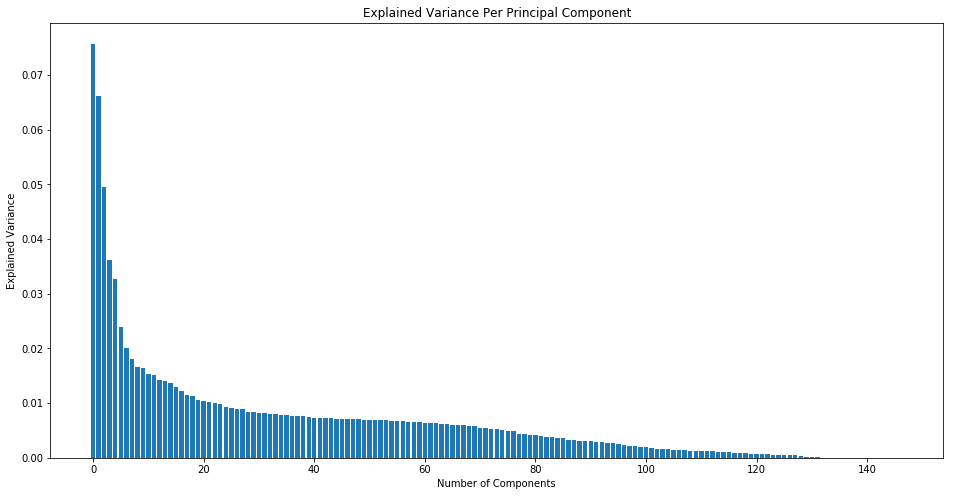

In [108]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(16, 8))
plt.bar(np.arange(num_components), explained_var)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("Explained Variance Per Principal Component");

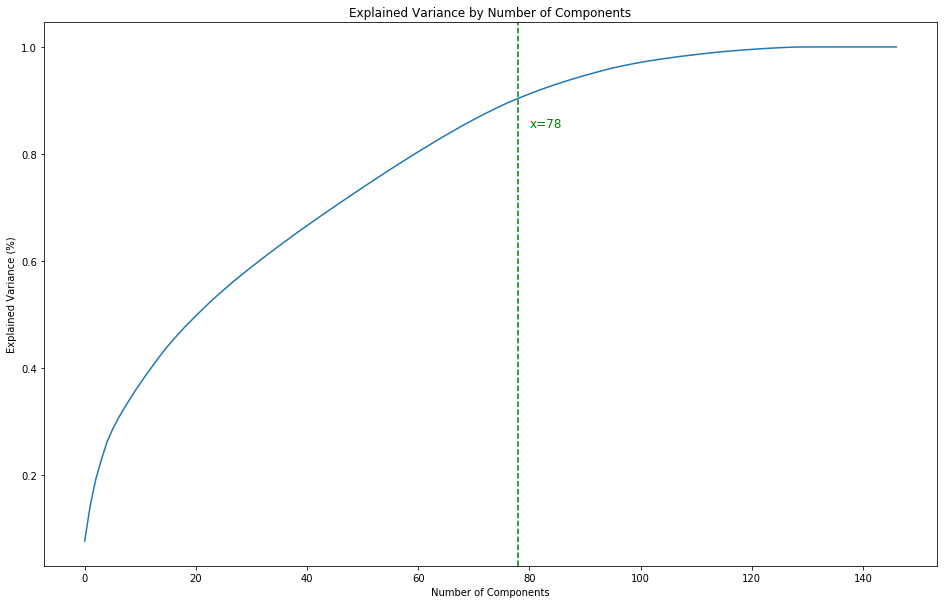

In [109]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(len(explained_var)), np.cumsum(explained_var));
x_90=np.searchsorted(np.cumsum(explained_var), 0.90)
plt.axvline(x=x_90, color='g', linestyle='--')
plt.text(x_90+2, 0.85, f"x={x_90}", color='g', fontsize=12)
plt.xlabel('Number of Components');
plt.ylabel('Explained Variance (%)');
plt.title('Explained Variance by Number of Components');

In [110]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_78 = PCA(n_components = 78)
pca_78.fit(clean_azdias_scaled)
azdias_pca = pca_78.transform(clean_azdias_scaled)

In [111]:
pca_78.components_.shape

(78, 147)

### Discussion 2.2: Perform Dimensionality Reduction
> After looking at the visualisations above I could see that the first 80-100 components contained almost 90% of the data. By adding the dotted line and 'x-value' at 90% of the data I found that the first 78 components contain 90% of the data so I chose this as the number of components to re-apply PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [112]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights(data,pca,n_component):
    
    # Map weights for nth component to corresponding feature names and sort
    df = pd.DataFrame({'weight':pca.components_[n_component-1]}, index=data.columns)
    df.sort_values(by='weight',inplace=True)
    df_top5 = pd.concat([df.head(5),df.tail(5)])

    
    # Print top 5 negative and positive weights
    print(f'Top 5 Positive weights for component {n_component} to corresponding feature:\n {df[-5:]}\n')
    print(f'Top 5 Negative weights for component {n_component} to corresponding feature:\n {df[:5]}\n')
    
    # Plot top 5 negative and positive weights
    ax = df_top5.plot.bar(rot=90)
    ax.set_ylabel('Feature Weights')
    ax.set_xlabel('Features')
    plt.show()

    return

Top 5 Positive weights for component 1 to corresponding feature:
                           weight
PLZ8_ANTG3              0.164602
PLZ8_ANTG4              0.173042
CAMEO_INTL_2015_Wealth  0.179393
HH_EINKOMMEN_SCORE      0.211698
FINANZ_HAUSBAUER        0.236360

Top 5 Negative weights for component 1 to corresponding feature:
                      weight
KBA05_GBZ         -0.206645
MIN_GEBAEUDEJAHR  -0.180070
FINANZTYP_3       -0.162160
FINANZ_MINIMALIST -0.155983
KONSUMNAEHE       -0.153007



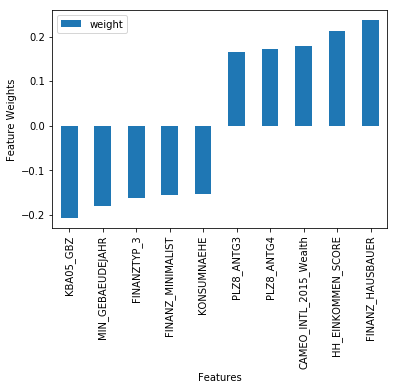

In [113]:
map_weights(clean_azdias_scaled,pca_78,1)

Top 5 Positive weights for component 2 to corresponding feature:
                         weight
FINANZTYP_2           0.167697
ZABEOTYP_3            0.190346
FINANZ_MINIMALIST     0.211563
ALTERSKATEGORIE_GROB  0.236968
FINANZ_VORSORGER      0.249751

Top 5 Negative weights for component 2 to corresponding feature:
                                 weight
FINANZ_SPARER                -0.285313
FINANZ_UNAUFFAELLIGER        -0.242261
FINANZ_ANLEGER               -0.235006
SEMIO_TRADV                  -0.212391
PRAEGENDE_JUGENDJAHRE_Decade -0.211087



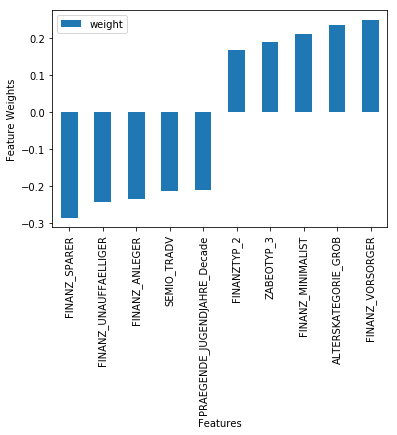

In [114]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(clean_azdias_scaled,pca_78,2)

Top 5 Positive weights for component 3 to corresponding feature:
               weight
SEMIO_REL   0.130985
SEMIO_SOZ   0.247275
SEMIO_VERT  0.265797
SEMIO_FAM   0.274363
SEMIO_KULT  0.299758

Top 5 Negative weights for component 3 to corresponding feature:
               weight
ANREDE_KZ  -0.319033
SEMIO_KRIT -0.310590
SEMIO_DOM  -0.290923
SEMIO_KAEM -0.287379
SEMIO_ERL  -0.239479



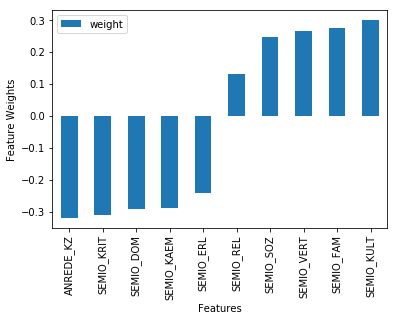

In [115]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(clean_azdias_scaled,pca_78,3)

### Discussion 2.3: Interpret Principal Components
1. **First Principal Component:** Most of the components seems to have an association with number of family houses in an area and household wealth
    - Has a Positive interpretation with:
        - PLZ8_ANTG3(Number of 6-10 family houses in the region)
        - PLZ8_ANTG4(Number of 10+ family houses in the region)
        - CAMEO_INTL_2015_Wealth(Household wealth)
        - HH_EINKOMMEN_SCORE(Estimated household net income)
        - FINANZ_HAUSBAUER(Financial typology)
    - Has a Negative interpretation with:
        - KBA05_GBZ(Number of buildings in the microcell)
        - MIN_GEBAEUDEJAHR(First year building was mentioned in the database)
        - FINANZTYP_3(Most descriptive financial type for individual-home ownership)
        - FINANZ_MINIMALIST(Financial typology)
        - KONSUMNAEHE(Distance from building to point of sale (PoS))


2. **Second Principal Component:** This component mostly has associations with financial typology and age
    - Has a Positive interpretation with:
        - FINANZTYP_2(Most descriptive financial type for individual-money-saver )
        - ZABEOTYP_3(Energy consumption typology-fair supplied)
        - FINANZ_MINIMALIST(Financial typology)
        - ALTERSKATEGORIE_GROB(Estimated age based on given name analysis)
        - FINANZ_VORSORGER(Financial typology)
    - Has a Negative interpretation with:
        - FINANZ_SPARER(Financial typology)
        - FINANZ_UNAUFFAELLIGER(Financial typology)
        - FINANZ_ANLEGER(Financial typology)
        - SEMIO_TRADV(Personality typology)
        - PRAEGENDE_JUGENDJAHRE_Decade(Dominating movement of person's youth - by decade)

3. **Third Principal Component:** With this last component there is almost entirely associations with personality type and one gender for the top 5 positive and negative weights
    - Has a Positive interpretation with:
        - SEMIO_REL(Personality typology)
        - SEMIO_SOZ(Personality typology)
        - SEMIO_VERT(Personality typology)
        - SEMIO_FAM(Personality typology)
        - SEMIO_KULT(Personality typology)
    - Has a Negative interpretation with:
        - ANREDE_KZ(Gender)
        - SEMIO_KRIT(Personality typology)
        - SEMIO_DOM(Personality typology)
        - SEMIO_KAEM(Personality typology)
        - SEMIO_ERL(Personality typology)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [116]:
def get_kmeans_scores(data,cluster_range):
    '''
    Over a number of different cluster counts returns the kmeans score 
    INPUT:
        data - the dataset used to fit kmeans to
        cluster_range - the number of cluster you want
    OUTPUT:
        scores -  the average scores within-cluster distances
    '''
    scores = []
    cluster_counts = cluster_range
    
    for i in cluster_counts:
        # run k-means clustering on the data and...
        kmeans = KMeans(i,random_state=0)
        model = kmeans.fit(data)
        
        # compute the average within-cluster distances.
        scores.append(np.abs(model.score(data)))
    return(cluster_counts,scores)


In [117]:
 clusters,kmeans_scores = get_kmeans_scores(azdias_pca,range(1,21))

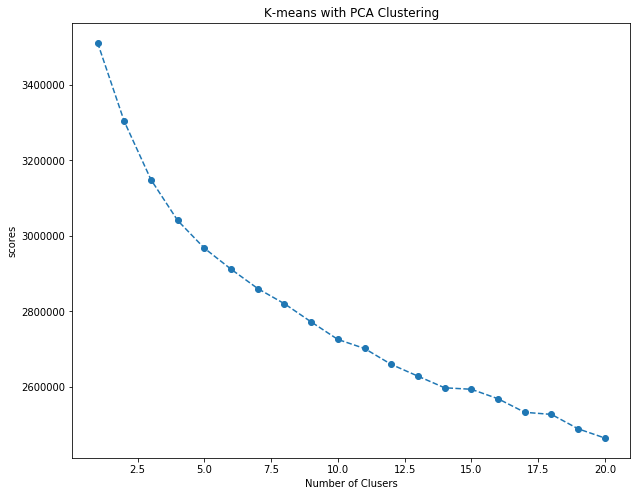

In [118]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize = (10,8))
plt.plot(clusters, kmeans_scores, linestyle='--',marker='o');
plt.xlabel('Number of Clusers')
plt.ylabel('scores')
plt.title('K-means with PCA Clustering')
plt.show()

In [119]:
 clusters,kmeans_scores = get_kmeans_scores(azdias_pca,range(1,16))

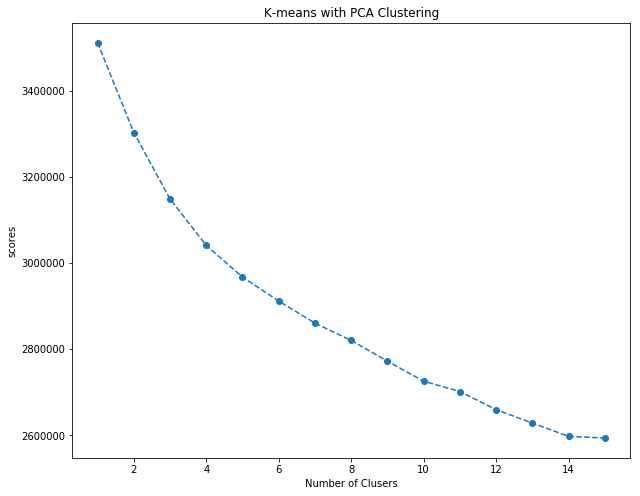

In [120]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize = (10,8))
plt.plot(clusters, kmeans_scores, linestyle='--',marker='o');
plt.xlabel('Number of Clusers')
plt.ylabel('scores')
plt.title('K-means with PCA Clustering')
plt.show()

In [121]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(15,random_state=0)
azdias_predict = kmeans.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population
> Using the elbow method I looked at the scores for a range of clusters between 1-20 and 1-15. With the first range of clusters there wasn't a clear substantial decrease in the average distance however two points in the graph stood out, 8 and 15. I looked at the range of clusters between 1-15 to see if this would become clearer but the change seemed even less obvious. With the initial range I decided to use a k-means value of 15.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [125]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
feat_info_customers = feat_info.copy()

In [126]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Preprocessing Data
customers_clean, customers_ut = clean_data(customers, feat_info_customers, col_to_drop) #Using columns to drop from analysis of general pop

print('Total rows and columns in original dataset:', customers.shape)
print('Total rows and columns in cleaned dataset:', customers_clean.shape)
print('Total values in cleaned dataset:', customers_clean.shape[0]*customers_clean.shape[1])
print('Total null values in cleaned dataset:', customers_clean.isna().sum().sum())

Binary Features:['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-Level Features:['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Total rows and columns in original dataset: (191652, 85)
Total rows and columns in cleaned dataset: (5972, 147)
Total values in cleaned dataset: 877884
Total null values in cleaned dataset: 0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [127]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_Stage
0,2.0,1.0,4.0,4.0,2.0,1.0,5.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0,2.0
1,4.0,2.0,5.0,1.0,5.0,1.0,3.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0
2,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,4.0
3,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,4.0,3.0
4,4.0,2.0,3.0,1.0,5.0,1.0,3.0,5.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,4.0


In [128]:
customers_clean.shape

(5972, 147)

In [129]:
# Feature transformation

# Apply feature scaling to the general Customer demographics data.
# Create clean scaled/transormed dataframe
clean_customers_scaled = pd.DataFrame(scaler.fit_transform(customers_clean), columns=customers_clean.columns)

In [130]:
clean_customers_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_Movement,PRAEGENDE_JUGENDJAHRE_Decade,CAMEO_INTL_2015_Wealth,CAMEO_INTL_2015_Life_Stage
0,2.27061,2.079346,3.720316,3.860854,1.973066,0.893329,4.284970,0.73958,2.080588,2.558715,...,0.0,0.000000,0.000000,0.0,0.0,0.0,2.080588,6.348079,0.745076,1.490602
1,4.54122,4.158693,4.650395,0.965214,4.932665,0.893329,2.570982,1.47916,0.000000,2.558715,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,3.526710,0.745076,2.981203
2,4.54122,2.079346,4.650395,0.965214,4.932665,0.893329,0.856994,1.47916,2.080588,1.279357,...,0.0,0.000000,0.000000,0.0,0.0,0.0,2.080588,3.526710,0.745076,2.981203
3,4.54122,2.079346,4.650395,0.965214,4.932665,0.893329,0.856994,1.47916,2.080588,1.279357,...,0.0,0.000000,3.132162,0.0,0.0,0.0,2.080588,3.526710,2.980306,2.235903
4,4.54122,4.158693,2.790237,0.965214,4.932665,0.893329,2.570982,3.69790,0.000000,2.558715,...,0.0,3.280771,0.000000,0.0,0.0,0.0,0.000000,3.526710,2.235229,2.981203


In [131]:
# Apply PCA to the data while selecting for number of components to retain.
customers_pca = pca_78.transform(clean_customers_scaled)

In [132]:
# Fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the customer demographics data.
customer_predict = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

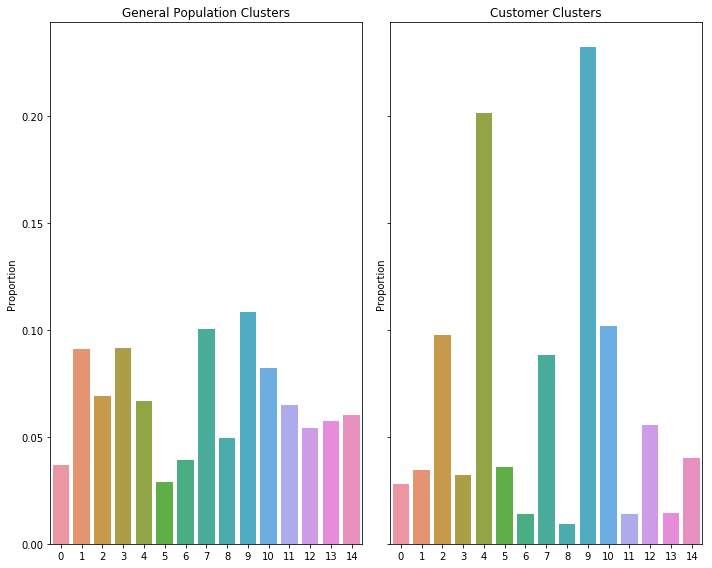

In [154]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_prop = pd.Series(azdias_predict).value_counts(normalize=True)
customer_prop = pd.Series(customer_predict).value_counts(normalize=True)

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, sharey=True, ncols=2, figsize=(10,8))

# Plot the proportions as bar charts using sns.barplot
sns.barplot(x=azdias_prop.index, y=azdias_prop.values, ax=ax[0])
ax[0].set_ylabel('Proportion')
ax[0].set_title('General Population Clusters')

sns.barplot(x=customer_prop.index, y=customer_prop.values, ax=ax[1])
ax[1].set_ylabel('Proportion')
ax[1].set_title('Customer Clusters')

fig.tight_layout()

Source for above code is: https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group

In [149]:
# Account for data with upper threshold of missing values
azdias_ut_array = np.full((azdias_ut.shape[0],), -1)
all_azdias = np.concatenate([azdias_predict, azdias_ut_array])

customers_ut_array = np.full((customers_ut.shape[0],), -1)
all_customers = np.concatenate([customer_predict, customers_ut_array])

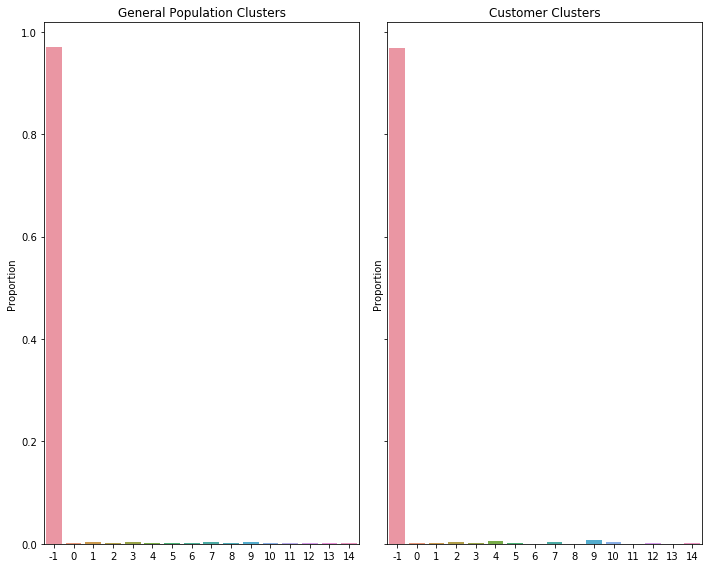

In [152]:
all_azdias_prop = pd.Series(all_azdias).value_counts(normalize=True)
all_customer_prop = pd.Series(all_customers).value_counts(normalize=True)

# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, sharey=True, ncols=2, figsize=(10,8))

# Plot the proportions as bar charts using sns.barplot
sns.barplot(x=all_azdias_prop.index, y=all_azdias_prop.values, ax=ax[0])
ax[0].set_ylabel('Proportion')
ax[0].set_title('General Population Clusters')

sns.barplot(x=all_customer_prop.index, y=all_customer_prop.values, ax=ax[1])
ax[1].set_ylabel('Proportion')
ax[1].set_title('Customer Clusters')

fig.tight_layout()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.